In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
import matplotlib.pyplot as plt
print(torch.__version__)
print(torch.cuda.is_available())
class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv2d, self).__init__()
        self.depthwise_conv = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels)
        self.pointwise_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        return x

class MobileNetEncoder(nn.Module):
    def __init__(self, in_channels=3):
        super(MobileNetEncoder, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            # nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            DepthwiseSeparableConv2d(8, 16),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=1, stride=2, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            DepthwiseSeparableConv2d(16, 16),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=1, stride=2, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            DepthwiseSeparableConv2d(32, 32),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=1, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv5 = nn.Sequential(
            DepthwiseSeparableConv2d(64, 64),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=1, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv6 = nn.Sequential(
            DepthwiseSeparableConv2d(128, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=1, stride=2, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)
        x6 = self.conv6(x5)
        return x1, x2, x3, x4, x5, x6

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, output_act = nn.Sigmoid(), find_threshold = False):
        super(UNet, self).__init__()
        self.lane_threshold = 0.5
        self.output_act = output_act
        self.roc_flag = find_threshold
        # Encoder
        self.encoder = MobileNetEncoder(in_channels=n_channels)
        
        # Decoder

        self.upconv5 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.iconv5 = nn.Conv2d(256, 128, kernel_size=1)
        self.decoder_block5_1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(256, 128, kernel_size=1, bias=False),
            nn.BatchNorm2d(128),
            # nn.ReLU(inplace=True),
        )
        self.decoder_block5_2 = nn.Sequential(
            nn.Conv2d(128*2, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            # nn.ReLU(inplace=True),
        )

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.iconv4 = nn.Conv2d(128, 64, kernel_size=1)
        self.decoder_block4_1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64)
            # nn.ReLU(inplace=True),
        )
        self.decoder_block4_2 = nn.Sequential(
            nn.Conv2d(64*2, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            # nn.ReLU(inplace=True),
        )


        self.upconv3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.iconv3 = nn.Conv2d(64, 32, kernel_size=1)
        self.decoder_block3_1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 32, kernel_size=1, bias=False),
            nn.BatchNorm2d(32)
            # nn.ReLU(inplace=True),
        )
        self.decoder_block3_2 = nn.Sequential(
            nn.Conv2d(32*2, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            # nn.ReLU(inplace=True),
        )
        
        self.upconv2 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.iconv2 = nn.Conv2d(32, 16, kernel_size=1)
        self.decoder_block2_1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(32, 16, kernel_size=1, bias=False),
            nn.BatchNorm2d(16)
            # nn.ReLU(inplace=True),
        )
        self.decoder_block2_2 = nn.Sequential(
            nn.Conv2d(16*2, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            # nn.ReLU(inplace=True),
        )
        
        self.upconv1 = nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2)
        # print(self.upconv1.shape)
        self.iconv1 = nn.Conv2d(16, 8, kernel_size=1)
        self.decoder_block1_1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(16, 8, kernel_size=1, bias=False),
            nn.BatchNorm2d(8)
            # nn.ReLU(inplace=True),
        )
        self.decoder_block1_2 = nn.Sequential(
            nn.Conv2d(8*2, 8, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(8),
            # nn.ReLU(inplace=True),
        )
        self.C2_layer = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1), 
            nn.BatchNorm2d(256))
        # self.C3_layer = nn.Conv2d(8, 8, kernel_size=1)
        self.C3_layer = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=1),
            nn.BatchNorm2d(8))
        self.output_layer = nn.Conv2d(8, n_classes, kernel_size=1)
            
    def forward(self, x):
        # print("Input shape: ", x.shape)
        x1, x2, x3, x4, x5, x6 = self.encoder(x)
        # print("Encoder output shapes: ", x1.shape, x2.shape, x3.shape, x4.shape, x5.shape, x6.shape)
        y6 = self.C2_layer(x6)
        # print("C2 layer shape: ", y6.shape)
        # UpSample
        y5 = self.decoder_block5_1(y6)
        # Concatenation with skip connection
        y5 = torch.cat([x5, y5], dim=1)
        # Conv2
        y5 = self.decoder_block5_2(y5)
        # print("1 - Decoder layer shape: ", y5.shape)
        # UpSample
        y4 = self.decoder_block4_1(y5)
        # Concatenation with skip connection
        y4 = torch.cat([x4, y4], dim=1)
        # Conv2
        y4 = self.decoder_block4_2(y4)
        # print("2 - Decoder layer shape: ", y4.shape)
        # UpSample
        y3 = self.decoder_block3_1(y4)
        # Concatenation with skip connection
        y3 = torch.cat([x3, y3], dim=1)
        # Conv2
        y3 = self.decoder_block3_2(y3)
        # print("3 - Decoder layer shape: ", y3.shape)
        # UpSample
        y2 = self.decoder_block2_1(y3)
        # Concatenation with skip connection
        y2 = torch.cat([x2, y2], dim=1)
        # Conv2
        y2 = self.decoder_block2_2(y2)
        # print("4 - Decoder layer shape: ", y2.shape)

        # UpSample
        y1 = self.decoder_block1_1(y2)
        # Concatenation with skip connection
        y1 = torch.cat([x1, y1], dim=1)
        # Conv2
        y1 = self.decoder_block1_2(y1)
        y1 = self.C3_layer(y1)
        # print("5 - Decoder layer shape: ", y1.shape)

        out = self.output_layer(y1)
        # Training time
        if self.training:
            act = self.output_act
            class_prob_masks = act(out)
            predictions = torch.where(class_prob_masks > self.lane_threshold, torch.ones_like(class_prob_masks), torch.zeros_like(class_prob_masks))
            return out, predictions
            # return class_prob_masks
        elif self.roc_flag and not self.training:
            act = self.output_act
            class_prob_masks = act(out)
            return class_prob_masks
        # Evaluation time
        else:
            act = self.output_act
            class_prob_masks = act(out)
            # Flatten the tensor into a 1D array
            x_flat = class_prob_masks.detach().cpu().numpy().flatten()
            # Plot a histogram of the tensor values
            plt.hist(x_flat, bins=100)
            plt.show()
            # print(class_prob_masks)
            predictions = torch.where(class_prob_masks > self.lane_threshold, torch.ones_like(class_prob_masks), torch.zeros_like(class_prob_masks))
            # return predictions
            return predictions
        # print("6 - Output layer shape: ", out.shape)
        # return out
    # Count pipeline trainable parameters
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    

1.12.0+cu116
True


In [2]:
import argparse
import json
import os
import shutil
import time
import numpy as np
import random
import cv2
import os
import json
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchmetrics import F1Score,JaccardIndex
import torchvision.transforms as transforms
# from torch_poly_lr_decay import PolynomialLRDecay

# Set seed for randomize functions (Ez reproduction of results)
random.seed(100)

# Import TuSimple loader
import sys
sys.path.insert(0,'../resources/')
from tusimple import TuSimple
import utils
# ROOT DIRECTORIES
root_dir = os.path.dirname(os.getcwd())
annotated_dir = os.path.join(root_dir,'datasets/tusimple/train_set/annotations')
clips_dir = os.path.join(root_dir,'datasets/tusimple/train_set/')
annotated = os.listdir(annotated_dir)

# Get path directories for clips and annotations for the TUSimple dataset + ground truth dictionary
annotations = list()
for gt_file in annotated:
    path = os.path.join(annotated_dir,gt_file)
    json_gt = [json.loads(line) for line in open(path)]
    annotations.append(json_gt)
    
annotations = [a for f in annotations for a in f]

dataset = TuSimple(train_annotations = annotations, train_img_dir = clips_dir, resize_to = (640,640), subset_size = 0.2, val_size= 0.01)
# Create train and validation splits / Always use del dataset to free memory after this
train_set, validation_set = dataset.train_val_split()
del dataset

In [3]:
# Lane weight
pos_weight = utils.calculate_class_weight(train_set)
print(pos_weight.int())

tensor(39, dtype=torch.int32)


In [6]:
train_set[0][1]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [9]:
utils.plot_img_pred(train_set[2][0], train_set[2][1])

In [6]:
# Custom training function for the CNN pipeline with schedule and SGD optimizer
def train(model, train_loader, val_loader = None, num_epochs=10, lr=0.1, momentum=0.9, weight_decay=0.001, lr_scheduler=True, lane_weight = None):
    # Set up loss function and optimizer
    criterion =  nn.BCEWithLogitsLoss(pos_weight= lane_weight)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Set up learning rate scheduler
    if lr_scheduler:
        scheduler = PolynomialLRDecay(optimizer, max_decay_steps=100, end_learning_rate=0.0001, power=0.9)

    # Set up device (GPU or CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    f1_score = F1Score(task="binary").to(device)
    iou_score = JaccardIndex(task= 'binary').to(device)
    
    train_augmentations = transforms.Compose([transforms.RandomRotation(degrees=(10, 30)),
                                              transforms.RandomHorizontalFlip()])
    
    # Set a seed for augmentations
    torch.manual_seed(42) 
    
    # Train the model
    for epoch in range(num_epochs):
        train_loss = 0
        train_iou = 0
        train_f1 = 0
        
        val_iou = 0
        val_f1 = 0
        
            
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            model.train()
            # Combine the inputs and targets into a single tensor
            data = torch.cat((inputs, targets), dim=1)
            # Apply the same augmentations to the combined tensor
            augmented_data = train_augmentations(data)    
    
            # Split the augmented data back into individual inputs and targets
            inputs = augmented_data[:, :inputs.size(1)].to(device)
            targets = augmented_data[:, inputs.size(1):].to(device)
      
            optimizer.zero_grad()
            outputs, eval_out = model(inputs)
            loss = criterion(outputs.to(device), targets)
            loss.backward()
            optimizer.step()
            
            
            train_loss += loss.item() * inputs.size(0)
            train_iou += iou_score(eval_out.to(device).detach(), targets)
            train_f1 += f1_score(eval_out.to(device).detach(),targets)
            
        if val_loader:
            model.eval()
            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(val_loader): 
                
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                
                    val_iou += iou_score(outputs.to(device), targets)
                    val_f1 += f1_score(outputs.to(device),targets)
        
                val_iou /= len(val_loader)
                val_f1 /= len(val_loader)
            
        train_loss /= len(train_loader)
        train_iou /= len(train_loader)
        train_f1 /= len(train_loader)
        
        
        
     # Print progress
        if lr_scheduler:
            print('Epoch: {} - Train Loss: {:.4f} - Learning Rate: {:.6f} - Train_IoU: {:.5f} - Train_F1: {:.5f}'.format(epoch+1, train_loss,optimizer.param_groups[0]['lr'], train_iou, train_f1))
            scheduler.step()
            if val_loader:
                print('Val_F1: {:.5f}  - Val_IoU: {:.5f} '.format(val_f1,val_iou))
        else:
            print('Epoch: {} - Train Loss: {:.4f} - Train_IoU: {:.5f} - Train_F1: {:.5f}'.format(epoch+1, train_loss, train_iou, train_f1))

In [3]:
# train_loader = DataLoader(train_set, batch_size=8, shuffle= True, drop_last= True)
# validation_loader = DataLoader(validation_set,batch_size=8, shuffle= True, drop_last= True)  
model = UNet()
print(f'Number of trainable parameters : {model.count_parameters()}')
# train(model, train_loader, val_loader = None, num_epochs= 5, lr_scheduler=False, lane_weight = pos_weight)

Number of trainable parameters : 793249


In [12]:
train(model, train_loader,val_loader= validation_loader,num_epochs= 5, lane_weight = pos_weight)

Epoch: 1 - Train Loss: 5.2155 - Learning Rate: 0.100000 - Train_IoU: 0.00332 - Train_F1: 0.00662
Epoch: 2 - Train Loss: 4.9140 - Learning Rate: 0.100000 - Train_IoU: 0.00352 - Train_F1: 0.00702
Epoch: 3 - Train Loss: 4.6149 - Learning Rate: 0.100000 - Train_IoU: 0.00373 - Train_F1: 0.00743
Epoch: 4 - Train Loss: 4.5529 - Learning Rate: 0.100000 - Train_IoU: 0.00375 - Train_F1: 0.00748
Epoch: 5 - Train Loss: 4.2586 - Learning Rate: 0.100000 - Train_IoU: 0.00403 - Train_F1: 0.00802


In [4]:
#LOAD SAVED MODEL FROM COLAB
model.load_state_dict(torch.load('CNN_model.pth'))

<All keys matched successfully>

In [5]:
model.lane_threshold = 0.1969800889492035
print(model.lane_threshold)

0.1969800889492035


torch.Size([3, 640, 640])
torch.Size([1, 3, 640, 640])


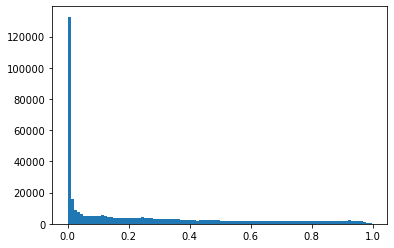

torch.Size([1, 1, 640, 640])


In [8]:
model.to(device='cuda').eval()
img_tns, gt = validation_set[5]
print(img_tns.shape)
img_tns_ = img_tns.unsqueeze(0)
print(img_tns_.shape)
img_tns_ = img_tns_.to('cuda')
pred_mask = model(img_tns_)
print(pred_mask.shape)

In [9]:
pred_mask = torch.squeeze(pred_mask)
pred_mask = utils.toImagearr(pred_mask)
img_tns = utils.toImagearr(img_tns)
print(pred_mask.shape)
print(img_tns.shape)
utils.disp_img(image = img_tns, name = 'Original Image')
utils.disp_img(image = pred_mask, name = 'Original Image')
# img_tns.shape

(640, 640)
(640, 640, 3)
